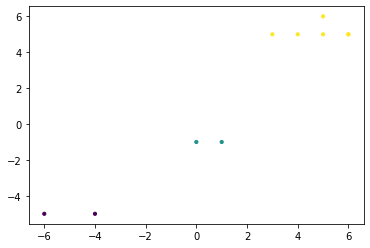

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import numpy as np
import collections
from sklearn.metrics import accuracy_score
from networkx import nx

%matplotlib inline
n_samples = 100
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=1.0,
                  centers=centers, shuffle=False, random_state=42)
X = np.rint(X)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.9, random_state=42)

plt.scatter(X_train[:, 0],X_train[:, 1], s=10, c=y_train)

直接暴力计算距离最近的K个点

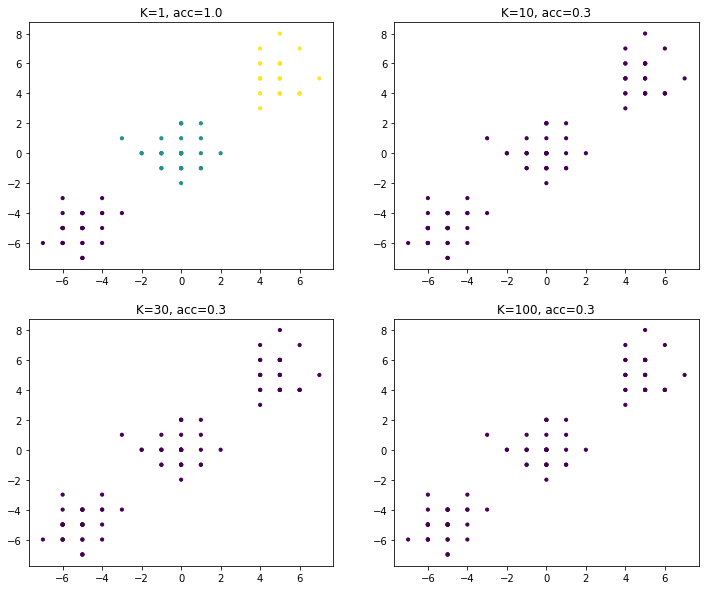

In [2]:
plt.figure(figsize=(12, 10))
for i, K in enumerate([1, 10, 30, 100]):
    ypred = []
    for x in X_test:
        neighbors = [(np.sum(np.square(x0-x)), y0) for x0, y0 in zip(X_train, y_train)]
        neighbors.sort()
        neighbors = neighbors[:K]
        wc = collections.Counter([c for v, c in neighbors])
        c = max(wc.values())
        w = [w for w in wc.keys() if wc[w] == c][0]
        ypred.append(w)

    acc = accuracy_score(ypred, y_test)
    ax = plt.subplot(221+i)
    plt.title('K={}, acc={}'.format(K, acc))
    plt.scatter(X_test[:, 0], X_test[:, 1], s=10, c=ypred)


使用KD树

In [47]:
class KdTreeNode:
    def __init__(self, x, y, parent=None, split_by=None, split_feature_val_range=None, feature_max=None, feature_min=None, left=None, right=None):
        self.X = x
        self.y = y
        self.parent = parent
        self.left = left
        self.right = right
        self.id = '{:.2f}_{:.2f}_{}'.format(x[0], x[1], y)
        self.split_by = split_by
        self.split_feature_val_range = split_feature_val_range
        self.feature_max = feature_max
        self.feature_min = feature_min
        self.id = -1
        self.level = -1
    
    def label(self):
        return 'pos=({:.2f} ,{:.2f}) \n y={} \n split_by=feature_{}\nsplit_feature_val_range={}'.format(self.X.item(0), self.X.item(1), self.y, self.split_by, self.split_feature_val_range)

    def __lt__(self, other):
        return self.id < other.id
    
def build_kd_tree(X, Y, feature_index):
    if X.size == 0:
        return None

    # 按照第fi 个特征的中位数划分
    fi = feature_index % X.shape[1]
    feature_val = X[:, fi]
    split_feature_val_range = '({:.2f},{:.2f})'.format(np.min(feature_val), np.max(feature_val))
    feature_max = np.max(X, axis=0)
    feature_min = np.min(X, axis=0)
    sorted_index = np.argsort(feature_val)
    median_index = len(sorted_index) // 2

    x, y= X[sorted_index[median_index]], Y[sorted_index[median_index]]
    node = KdTreeNode(x, y, split_by=fi, split_feature_val_range=split_feature_val_range, feature_max=feature_max,
                      feature_min=feature_min)
    
    # 分别为小于和大于中位数的样本构建为左右子树
    node.left = build_kd_tree(np.take(X, sorted_index[:median_index], axis=0), np.take(Y, sorted_index[:median_index], axis=0), 
                              feature_index + 1)
    node.right = build_kd_tree(np.take(X, sorted_index[median_index + 1:], axis=0), np.take(Y, sorted_index[median_index + 1:], axis=0), 
                               feature_index + 1)
    if node.left:
        node.left.parent = node
    if node.right:
        node.right.parent = node

    return node


def set_node_id(treeNode, start):
    q = [(treeNode, 1)]
    while q:
        node, level = q[0]
        while q and q[0][1] == level:
            node, _ = q.pop(0)
            node.id = start
            node.level = level
            if node.left:
                q.append((node.left, level+1))
            if node.right:
                q.append((node.right, level+1))
            start += 1

    return start


kdTree = build_kd_tree(X_train, y_train, 0)
treeSize = set_node_id(kdTree, 1)

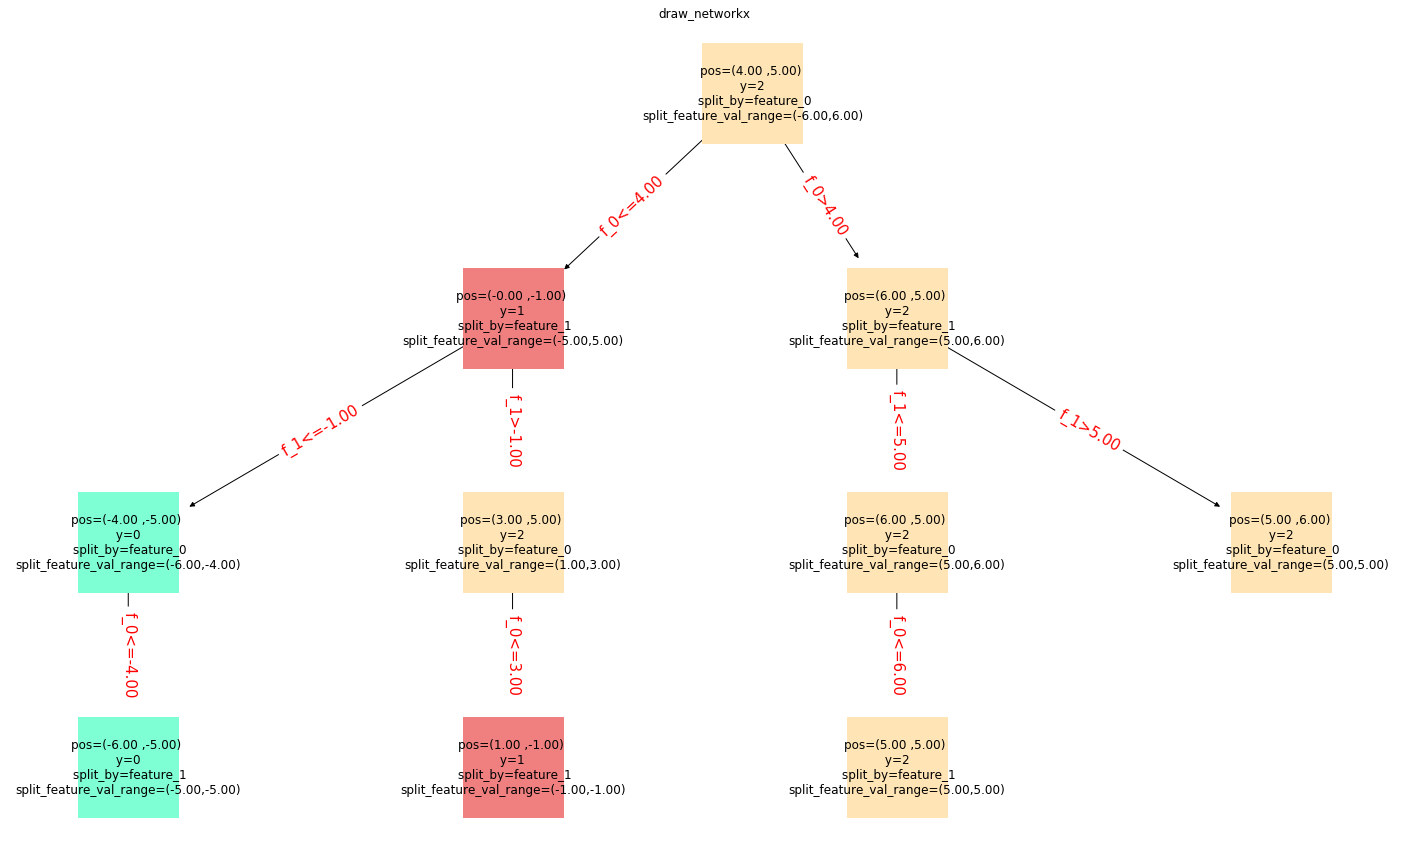

In [48]:
from networkx.drawing.nx_agraph import graphviz_layout

G = nx.DiGraph()

def build_graph(root):
    if not root:
        return
    
    G.add_node(root.id, label=root.label(), color=['aquamarine', 'lightcoral', 'moccasin'][root.y], y=root.y, s='x')
    
    if root.left:        
        build_graph(root.left)
        G.add_edge(root.id, root.left.id, label='f_{}<={:.2f}'.format(root.split_by, root.X[root.split_by]))

    if root.right:        
        build_graph(root.right)
        G.add_edge(root.id, root.right.id, label='f_{}>{:.2f}'.format(root.split_by, root.X[root.split_by]))

build_graph(kdTree)
fig = plt.figure(figsize=(25,15))
plt.title('draw_networkx')
pos=graphviz_layout(G, prog='dot', args='-Nshape=box, -Nwidth=200, -Nheight=200')
nx.draw(G, pos, with_labels=True, arrows=True, node_shape = 's', node_size=10000, \
        arrowstyle= '-|>', width=1, shape='square', node_color=[n[1] for n in G.nodes.data('color')], \
       labels = {n[0]:n[1] for n in G.nodes.data('label')})
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u[0], u[1]): u[2] for u in G.edges.data('label')}, font_color='red', font_size=15)
plt.show()

Text(-5.5, -1.1, 'target(-5, -1)')

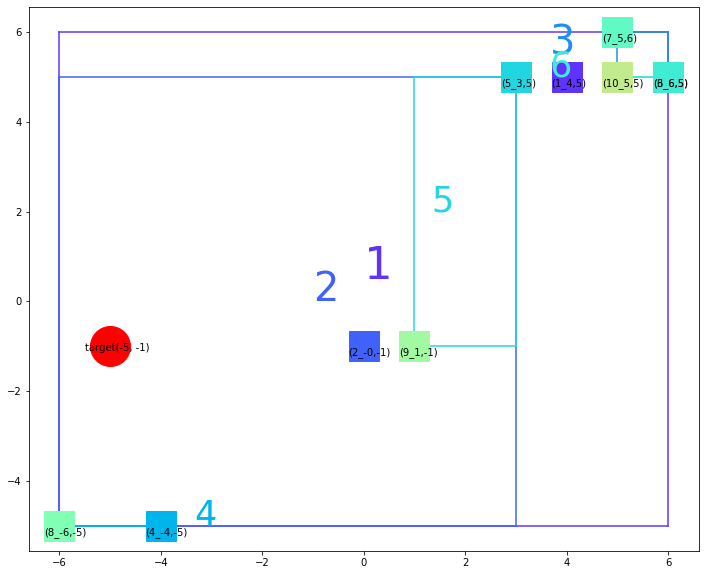

In [50]:
plt.figure(figsize=(12, 10))

cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=0, vmax=treeSize+5)
target = np.random.randint(-5, 5, 2)

def plot_split(tree_node):
    if not tree_node:
        return
    
    x0, x1 = tree_node.feature_min[0], tree_node.feature_max[0]
    y0, y1 = tree_node.feature_min[1], tree_node.feature_max[1]
    plt.plot([x0, x1], [y0, y0], c=cmap(norm(tree_node.id)))
    plt.plot([x0, x1], [y1, y1], c=cmap(norm(tree_node.id)))
    plt.plot([x0, x0], [y0, y1], c=cmap(norm(tree_node.id)))
    plt.plot([x1, x1], [y0, y1], c=cmap(norm(tree_node.id)))
    
    plt.plot([tree_node.X[0]], [tree_node.X[1]], marker='s', markersize=30, c=cmap(norm(tree_node.id)))
    plt.text(tree_node.X.item(0)-0.3, tree_node.X.item(1)-0.2, '({}_{:.0f},{:.0f})'.format(tree_node.id, tree_node.X[0], tree_node.X[1]))
    
    if x0 == x1 and y0 == y1:
        pass
    else:
        plt.text((x0+x1)/3, (y0+y1)/2, '{}'.format(tree_node.id), c=cmap(norm(tree_node.id)), fontsize=50-5*tree_node.level)
    plot_split(tree_node.left)
    plot_split(tree_node.right)

plot_split(kdTree)
plt.plot([target[0]], [target[1]], marker='o', color='r', markersize=40)
plt.text(target[0]-0.5, target[1]-0.1, 'target({:.0f}, {:.0f})'.format(target[0], target[1]))

**搜索KD树**

1. 在KD树中找到包含目标节点的叶子节点:从根节点出发,递归地向下访问,若目标点x当前维的值小于切分点的值则移动到左子树,反之则移动到右子树,直到叶子节点为止.
2. 以此叶子节点为最近的点
3. 递归地向上回退,在每个结点做如下操作:
    1. 如果该点更近,则以该点为最近点
    2. 检查该点的另外一个子结点的区间和以目标点为中心,当前最小距离为半径的圆是否有交点.检查目标点与该节点的分割超平面的距离即可.如果相交, 则搜索另一个子区间,否则回退.
    3. 回退到根节点,算法结束.

In [51]:
# 找到以当前节点为根的子树中离target最近的叶子结点.
def search_leaf(root, target):
    node = root
    while True:
        if not node.left and not node.right:
            break

        fi = node.split_by
        if target[fi] <= node.X[fi]:
            if node.left:
                node = node.left
            else:
                node = node.right
        else:
            if node.right:
                node = node.right
            else:
                node = node.left
    return node


# 计算距离
def dist(a, b):
    return np.linalg.norm(b - a, 2)


# 搜索离目标点最近的点
def search(node, target):
    # 找到叶子结点,作为当前最近的点
    leaf = search_leaf(node, target)
    ans = leaf
    mindist = dist(leaf.X, target)

    q = [leaf]
    # vis用于确保每个结点只入队列一次
    vis = {leaf.id}
    while q:
        node = q.pop()
        d = dist(node.X, target)
        if d < mindist:
            mindist = d
            ans = node

        parent = node.parent
        if not parent:
            continue

        # 回退到父结点
        if parent.id not in vis:
            vis.add(parent.id)
            q.append(parent)

        # 检查兄弟结点
        sib = parent.left if node != parent.left else parent.right
        if not sib or sib.id in vis:
            continue

        hyperplate = parent.split_by
        # 到超平面的距离, 因为分割平面只分割了某一个维度,所以距离是那个维度的坐标直接相减
        hyperdist = abs(parent.X[hyperplate] - target[hyperplate])
        # 到超平面的距离小于当前最小距离,那个兄弟结点所在的空间中可能存在更近的点,使兄弟结点入队列
        if hyperdist < mindist:
            sibleaf = search_leaf(sib, target)
            if sibleaf.id not in vis:
                vis.add(sibleaf.id)
                q.append(sibleaf)

    return ans, mindist

ans, d = search(kdTree, target)
print(dist(ans.X, target))
print('nearest to ({:.2f},{:.2f}) is ({:.2f}, {:.2f})), d={:.2f}'.format(target[0], target[1], ans.X[0], ans.X[1], d))

4.123105625617661
nearest to (-5.00,-1.00) is (-6.00, -5.00)), d=4.12


**查找最近的K个点**

保存一个最小堆即可

In [61]:
import heapq

# 搜索离目标点最近的点
def search_k(node, target, k):
    # 找到叶子结点,作为当前最近的点
    leaf = search_leaf(node, target)
    q = [leaf]
    kmin = []
    heapq.heapify(kmin)
    # vis用于确保每个结点只入队列一次
    vis = {leaf.id}
    
    while q:
        node = q.pop()
        d = dist(node.X, target)
        if len(kmin) < k:
            heapq.heappush(kmin, (-d, node))
        elif d < abs(kmin[0][0]):
            heapq.heappop(kmin)
            heapq.heappush(kmin, (-d, node))
        
        parent = node.parent
        if not parent:
            continue
        
        # 回退到父结点
        if parent.id not in vis:
            vis.add(parent.id)
            q.append(parent)
            
        # 检查兄弟结点
        sib = parent.left if node != parent.left else parent.right
        if not sib or sib.id in vis:
            continue
            
        hyperplate = parent.split_by
        # 到超平面的距离, 因为分割平面只分割了某一个维度,所以距离是那个维度的坐标直接相减
        hyperdist = abs(parent.X[hyperplate]-target[hyperplate])
        # 到超平面的距离小于当前最小距离,那个兄弟结点所在的空间中可能存在更近的点,使兄弟结点入队列
        if hyperdist < abs(kmin[0][0]):
            sibleaf = search_leaf(sib, target) 
            if sibleaf.id not in vis:
                vis.add(sibleaf.id)
                q.append(sibleaf)
                
    ans = []
    while kmin:
        d, node = heapq.heappop(kmin)
        ans.append((abs(d), node))
    return list(reversed(ans))

ans = search_k(kdTree, target, 5)
print([(v[0], v[1].X[0], v[1].X[1]) for v in ans])

print(list(sorted([(dist(x, target), x[0], x[1]) for x in X_train])))

[(4.123105625617661, -6.0, -5.0), (4.123105625617661, -4.0, -5.0), (5.0, -0.0, -1.0), (6.0, 1.0, -1.0), (10.0, 3.0, 5.0)]
[(4.123105625617661, -6.0, -5.0), (4.123105625617661, -4.0, -5.0), (5.0, -0.0, -1.0), (6.0, 1.0, -1.0), (10.0, 3.0, 5.0), (10.816653826391969, 4.0, 5.0), (11.661903789690601, 5.0, 5.0), (12.206555615733702, 5.0, 6.0), (12.529964086141668, 6.0, 5.0), (12.529964086141668, 6.0, 5.0)]
